In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.n_jobs = 6

scanpy==1.5.1 anndata==0.7.3 umap==0.4.3 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1


/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [3]:
adata = sc.read_10x_mtx("../data/Ileum/", cache=True)
adata

... reading from cache file cache/..-data-Ileum-matrix.h5ad


AnnData object with n_obs × n_vars = 39671 × 33660
    var: 'gene_ids'

In [4]:
obs = pd.read_table("../data/Ileum/Effi_tsne_final.txt", header=[0, 1])
obs.columns = [i[0] for i in obs.columns]
obs.index = obs.NAME
adata = adata[obs.NAME, :]
adata.obs = obs
adata.obs

,NAME,X,Y,Primary Lineages,kmeans
NAME,,,,,
122_AAACCTGGTTCCCGAG,122_AAACCTGGTTCCCGAG,-17.523981,25.760201,IgA plasma cells,5
122_AAAGATGTCAGCTCTC,122_AAAGATGTCAGCTCTC,-4.299636,-1.107461,Tregs,2
122_AAAGCAACAAGAAGAG,122_AAAGCAACAAGAAGAG,18.438143,-1.855235,Mast cells,17
122_AAATGCCTCACCCGAG,122_AAATGCCTCACCCGAG,8.266746,4.860057,TRM,3
122_AACCATGCATCACCCT,122_AACCATGCATCACCCT,1.359606,36.710104,IgA plasma cells,10
...,...,...,...,...,...
209_TTTGTCAGTCTCTTAT,209_TTTGTCAGTCTCTTAT,11.309222,21.416638,TRM,1
209_TTTGTCAGTGTGGTTT,209_TTTGTCAGTGTGGTTT,23.971407,1.429820,Group3 ILC,13
209_TTTGTCATCAGTTAGC,209_TTTGTCATCAGTTAGC,8.514284,0.595697,TRM,3


In [5]:
adata.obs['batch'] = adata.obs.NAME.str[0:3]

In [6]:
sample_info = pd.crosstab(adata.obs['batch'], adata.obs['Primary Lineages'])
sample_info.style

Primary Lineages,ACKR1+ endothelial cells,B cells,CD36+ endothelial cells,Central Memory T cells,Cytotoxic T cells,DC1,DC2,DC2 CD206+,Fibroblasts,Glial Cells,Group1 ILC,Group3 ILC,Highly activated T cells,IgA plasma cells,IgG plasma cells,IgM plasma cells,Lymphatics,Macrophages,Mast cells,Naive T cells,Pericytes,Plasmablasts,Smooth muscle cells,T (gd),TFH-like T cells,TRM,Tregs
batch,,,,,,,,,,,,,,,,,,,,,,,,,,,
122,1,10,0,4,2,2,19,1,6,0,7,20,2,142,7,13,0,6,19,1,0,0,0,7,10,145,13
128,76,641,2,82,34,12,27,8,16,0,63,5,129,248,415,61,1,18,4,20,7,26,1,19,79,172,146
138,67,1618,2,956,191,13,5,7,6,0,38,19,74,90,299,17,7,14,8,35,15,20,5,24,56,66,178
158,6,133,15,16,73,10,78,41,13,0,26,47,14,671,18,40,2,85,9,158,2,19,7,32,212,1305,100
181,60,2690,11,33,296,13,63,11,9,1,132,26,216,765,287,40,4,47,25,1566,3,71,2,54,1042,854,461
187,99,43,4,5,6,28,34,0,12,2,14,11,61,143,203,36,0,24,3,20,6,10,3,6,12,54,53
190,12,766,43,2,77,38,58,32,56,1,29,202,17,399,37,46,9,68,3,1073,8,10,17,49,229,1217,261
193,36,1462,41,11,51,14,162,83,18,4,343,89,52,1030,121,227,5,139,13,543,26,26,2,20,853,3014,448
196,10,239,19,8,39,10,77,29,49,0,36,40,29,567,137,79,2,115,4,15,5,33,17,9,171,515,223


In [7]:
sample_info.sum(axis=1)

batch
122     437
128    2312
138    3830
158    3132
181    8782
187     892
190    4759
193    8833
196    2477
209    4109
dtype: int64

In [8]:
adata = adata[adata.obs.batch == '193']

adata

View of AnnData object with n_obs × n_vars = 8833 × 33660
    obs: 'NAME', 'X', 'Y', 'Primary Lineages', 'kmeans', 'batch'
    var: 'gene_ids'

/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'Primary Lineages' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical


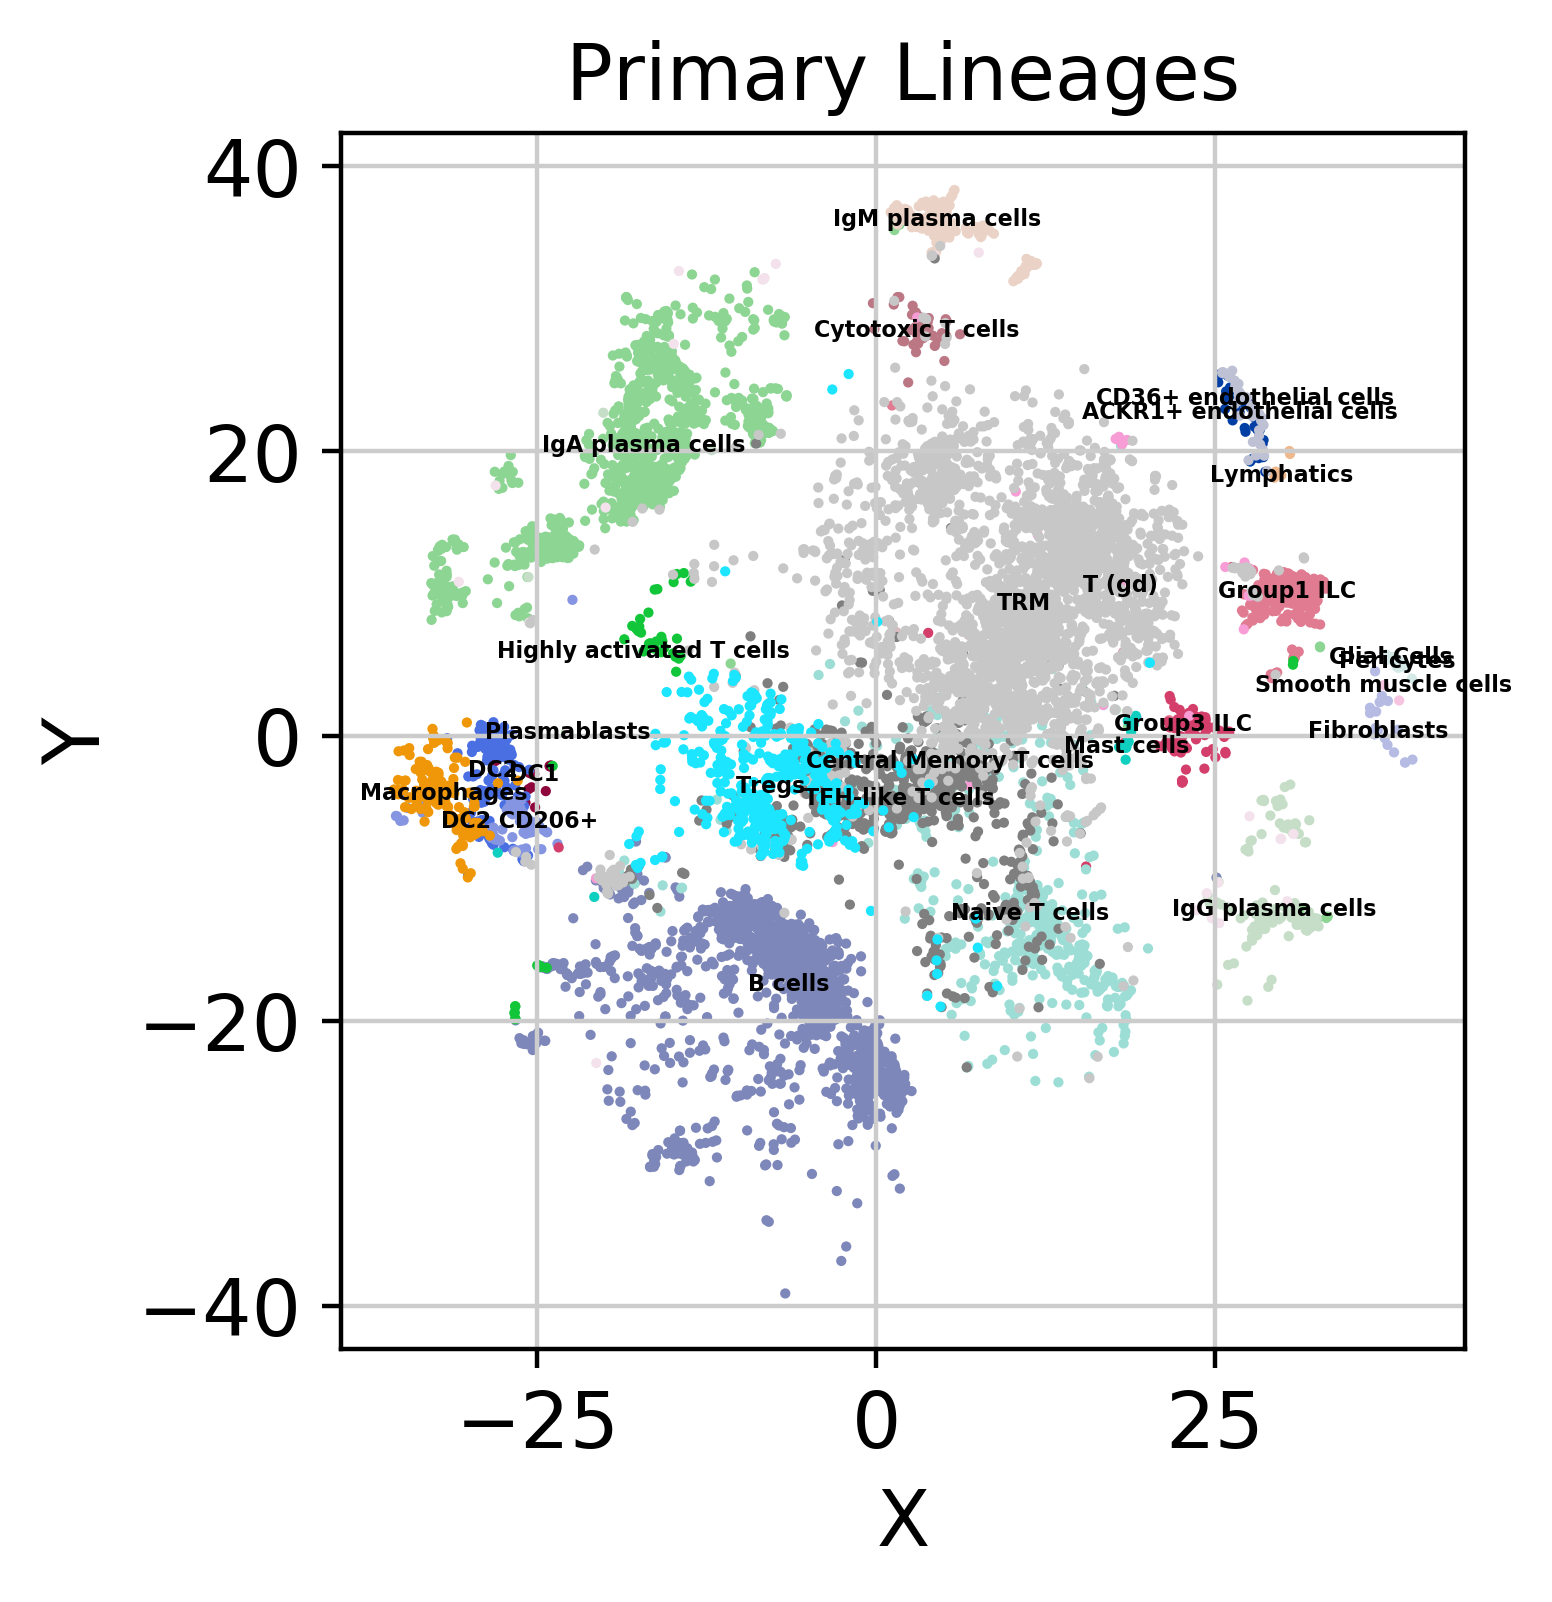

In [9]:
sc.settings.set_figure_params(dpi=200, facecolor='white')
sc.pl.scatter(adata, "X", "Y", "Primary Lineages", legend_loc="on data", legend_fontsize=4, frameon=False)

## QC

The dataset is already filtered, so no need to do additional QC.
Nevertheless, we show the figures.

normalizing counts per cell
    finished (0:00:00)


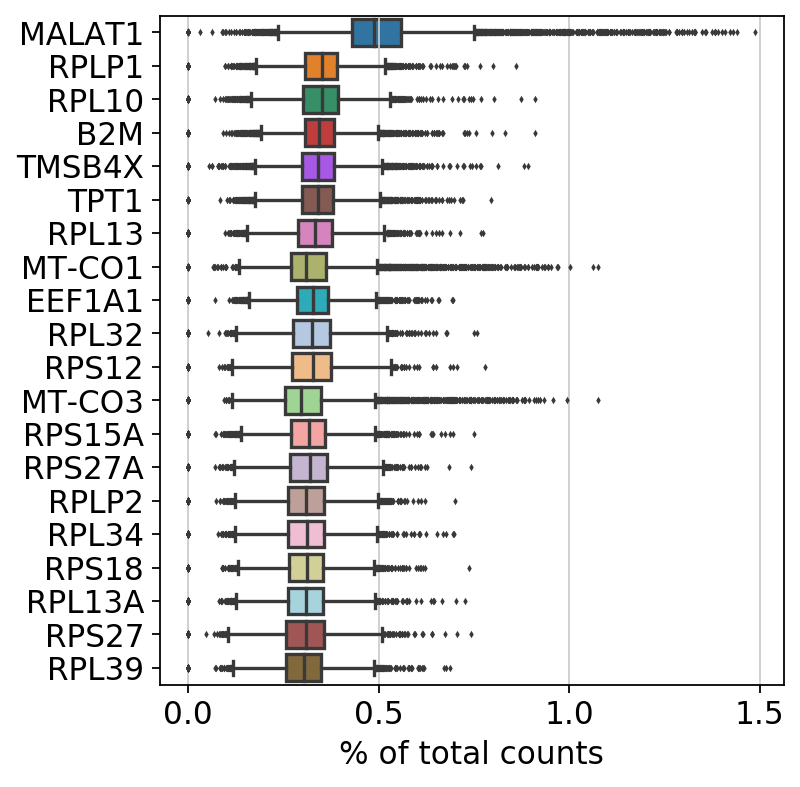

In [10]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pl.highest_expr_genes(adata, n_top=20)

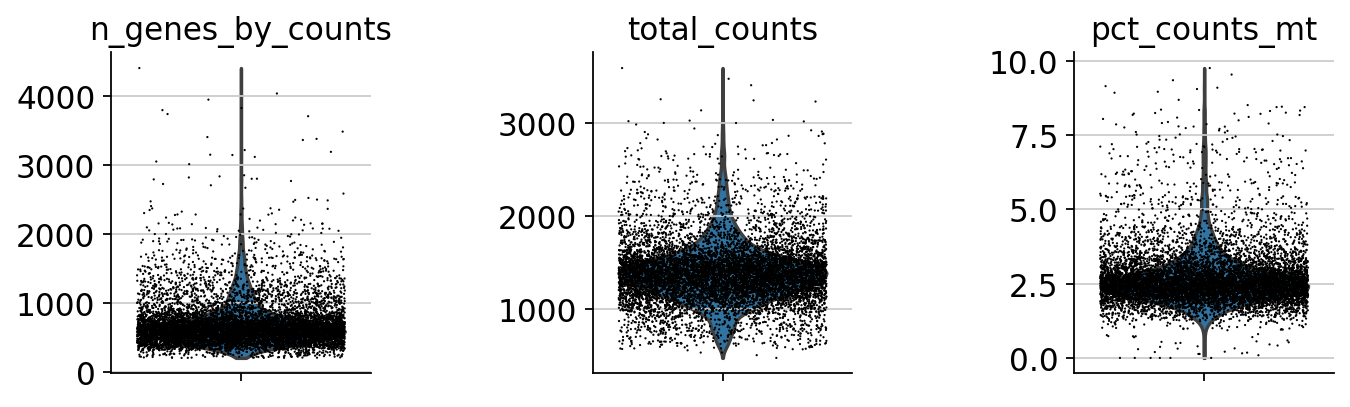

In [11]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

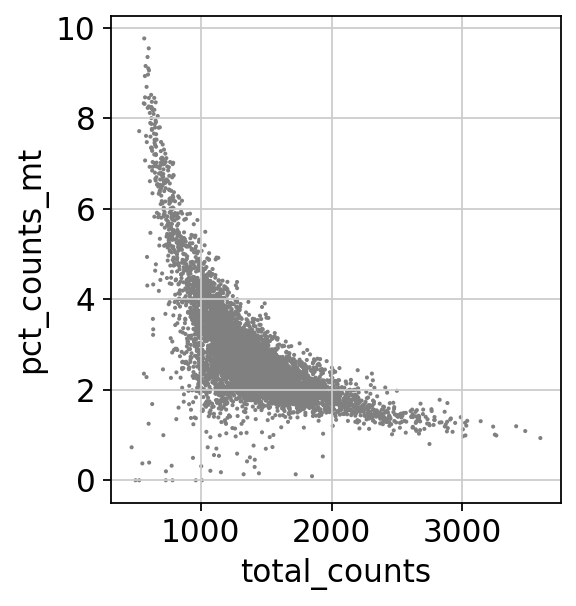

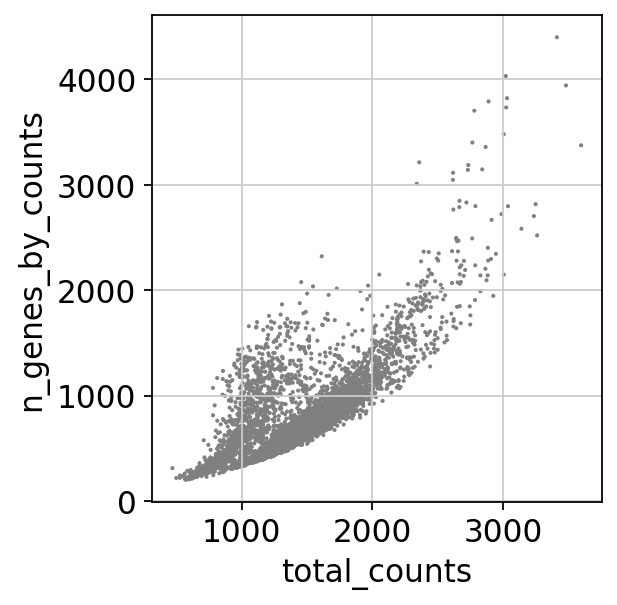

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
adata.raw = adata

In [14]:
sc.pp.filter_genes(adata, min_cells=2)

filtered out 14349 genes that are detected in less than 2 cells


In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


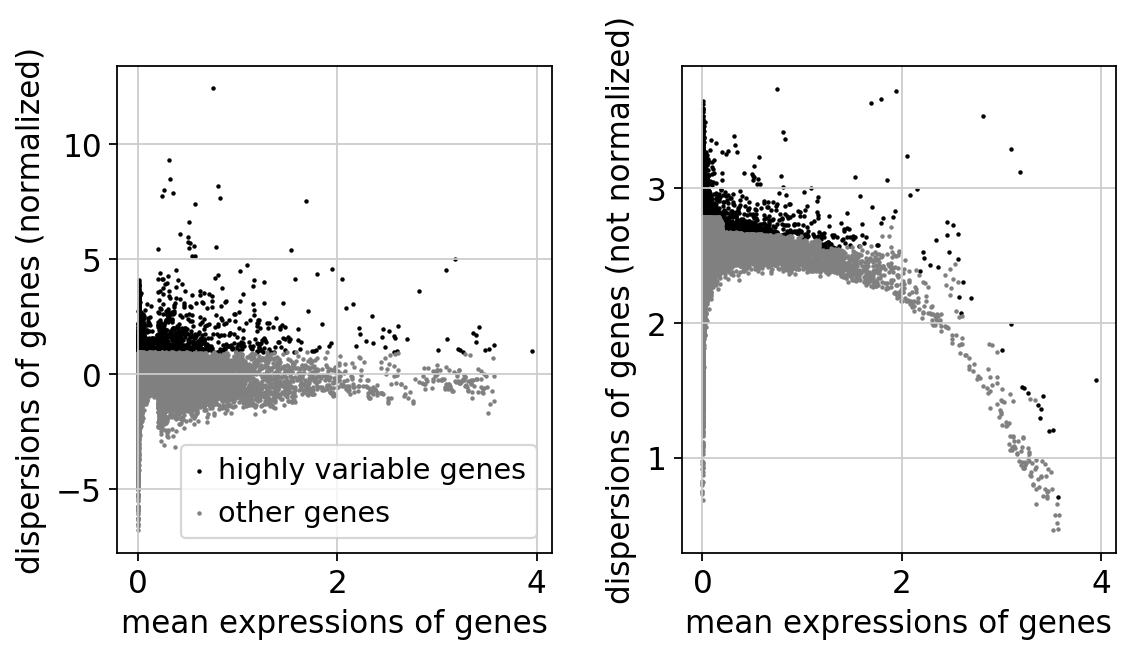

In [16]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

In [17]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 8833 × 2000
    obs: 'NAME', 'X', 'Y', 'Primary Lineages', 'kmeans', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Primary Lineages_colors', 'log1p'

In [18]:
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    on highly variable genes
    with n_comps=200
    finished (0:00:04)


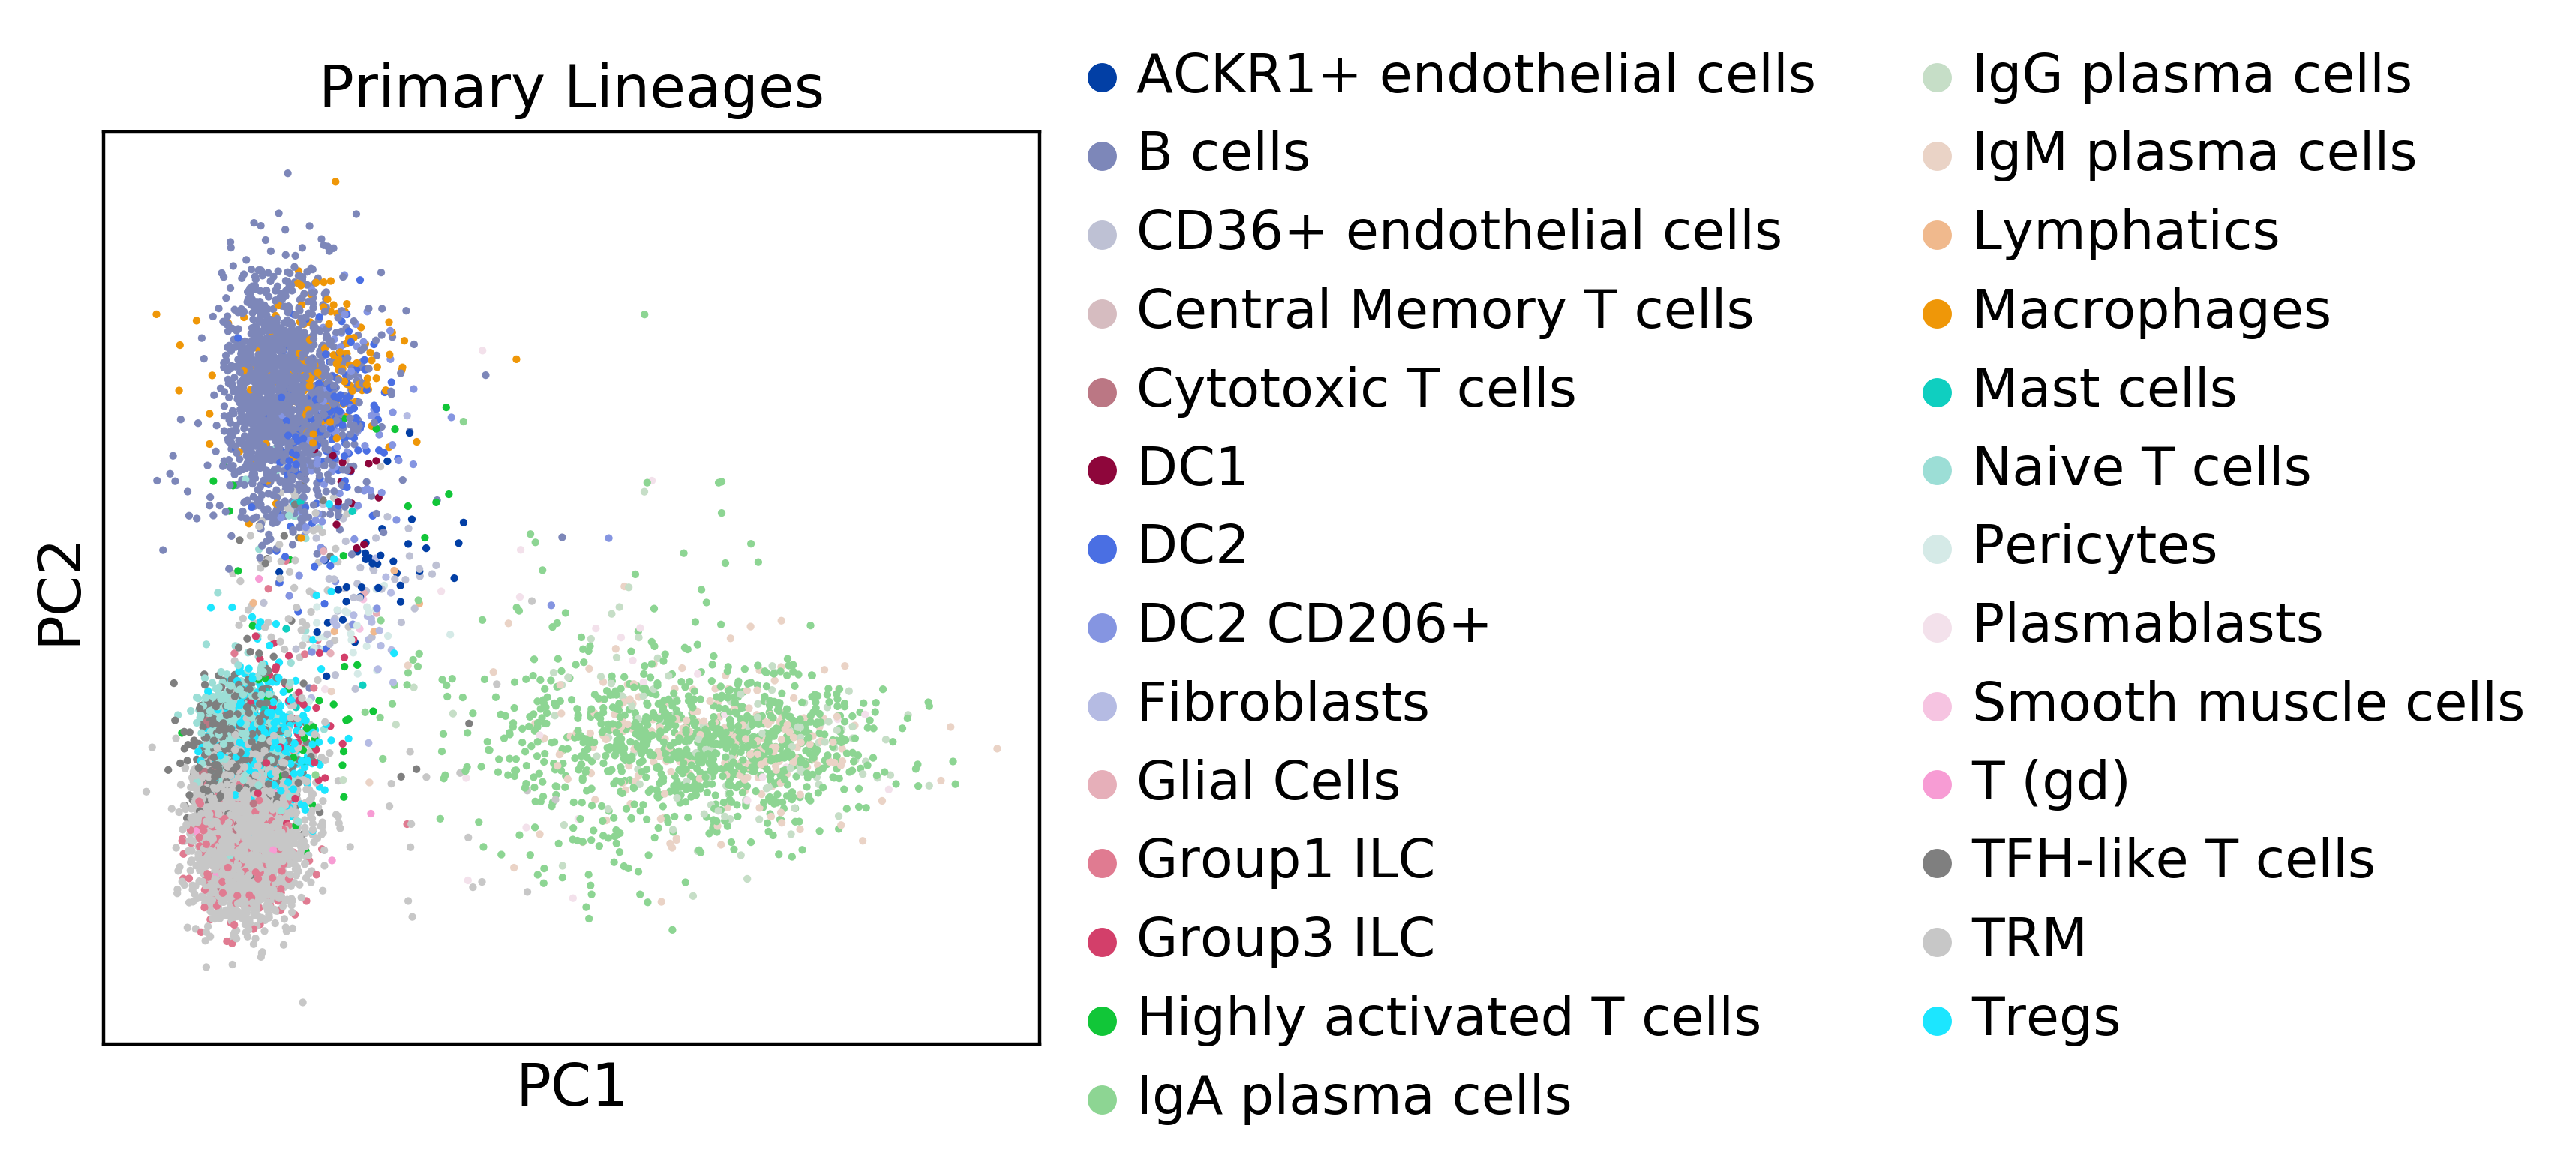

In [30]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=200)
sc.pl.pca(adata, color="Primary Lineages")

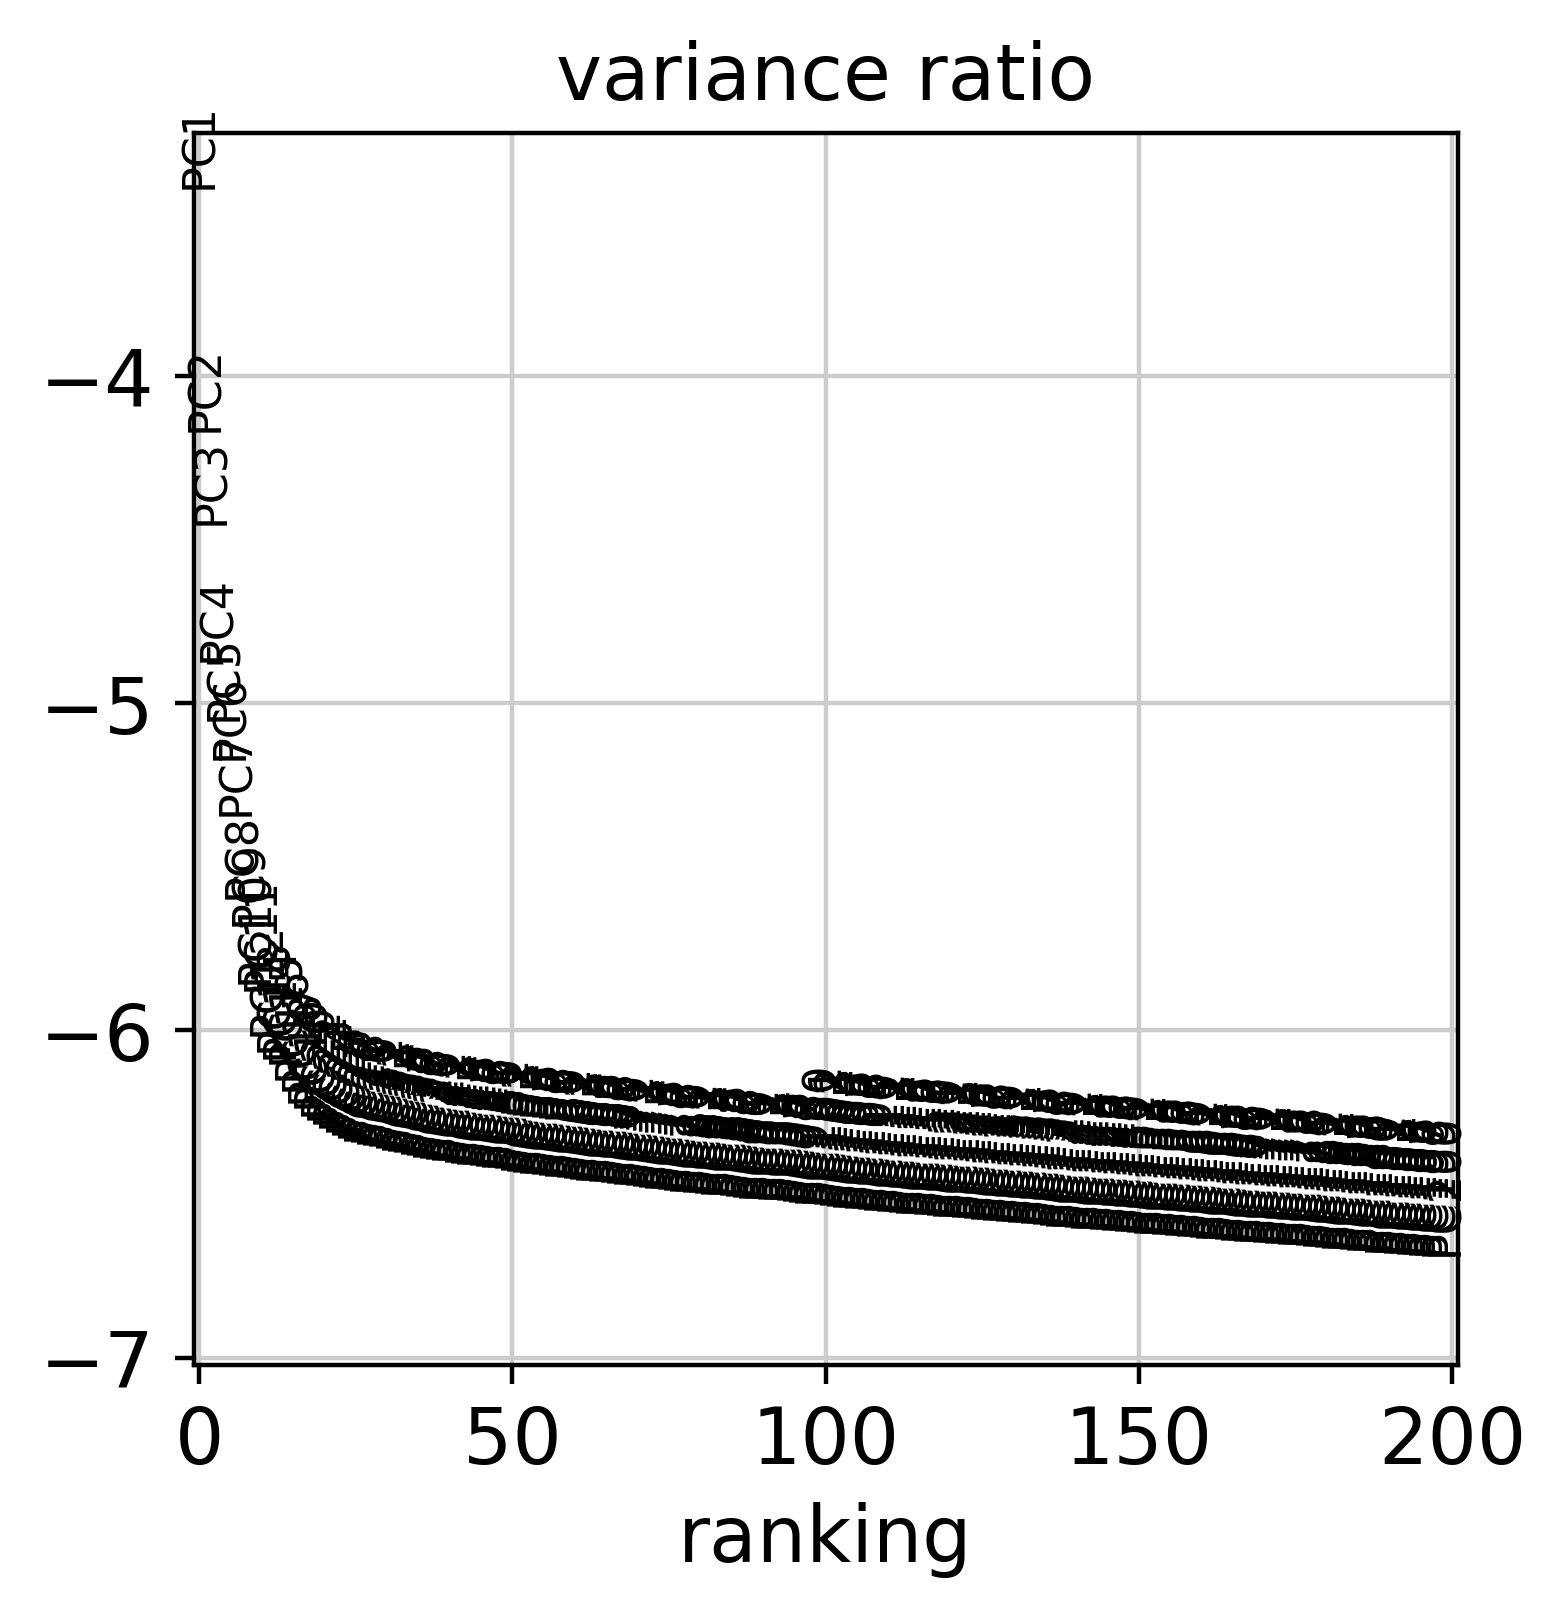

In [31]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=200)

In [32]:
# sc.tl.rank_genes_groups(adata, 'Primary Lineages', method='wilcoxon')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, ncols=3)

In [37]:
sc.pp.neighbors(adata, n_pcs=20)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


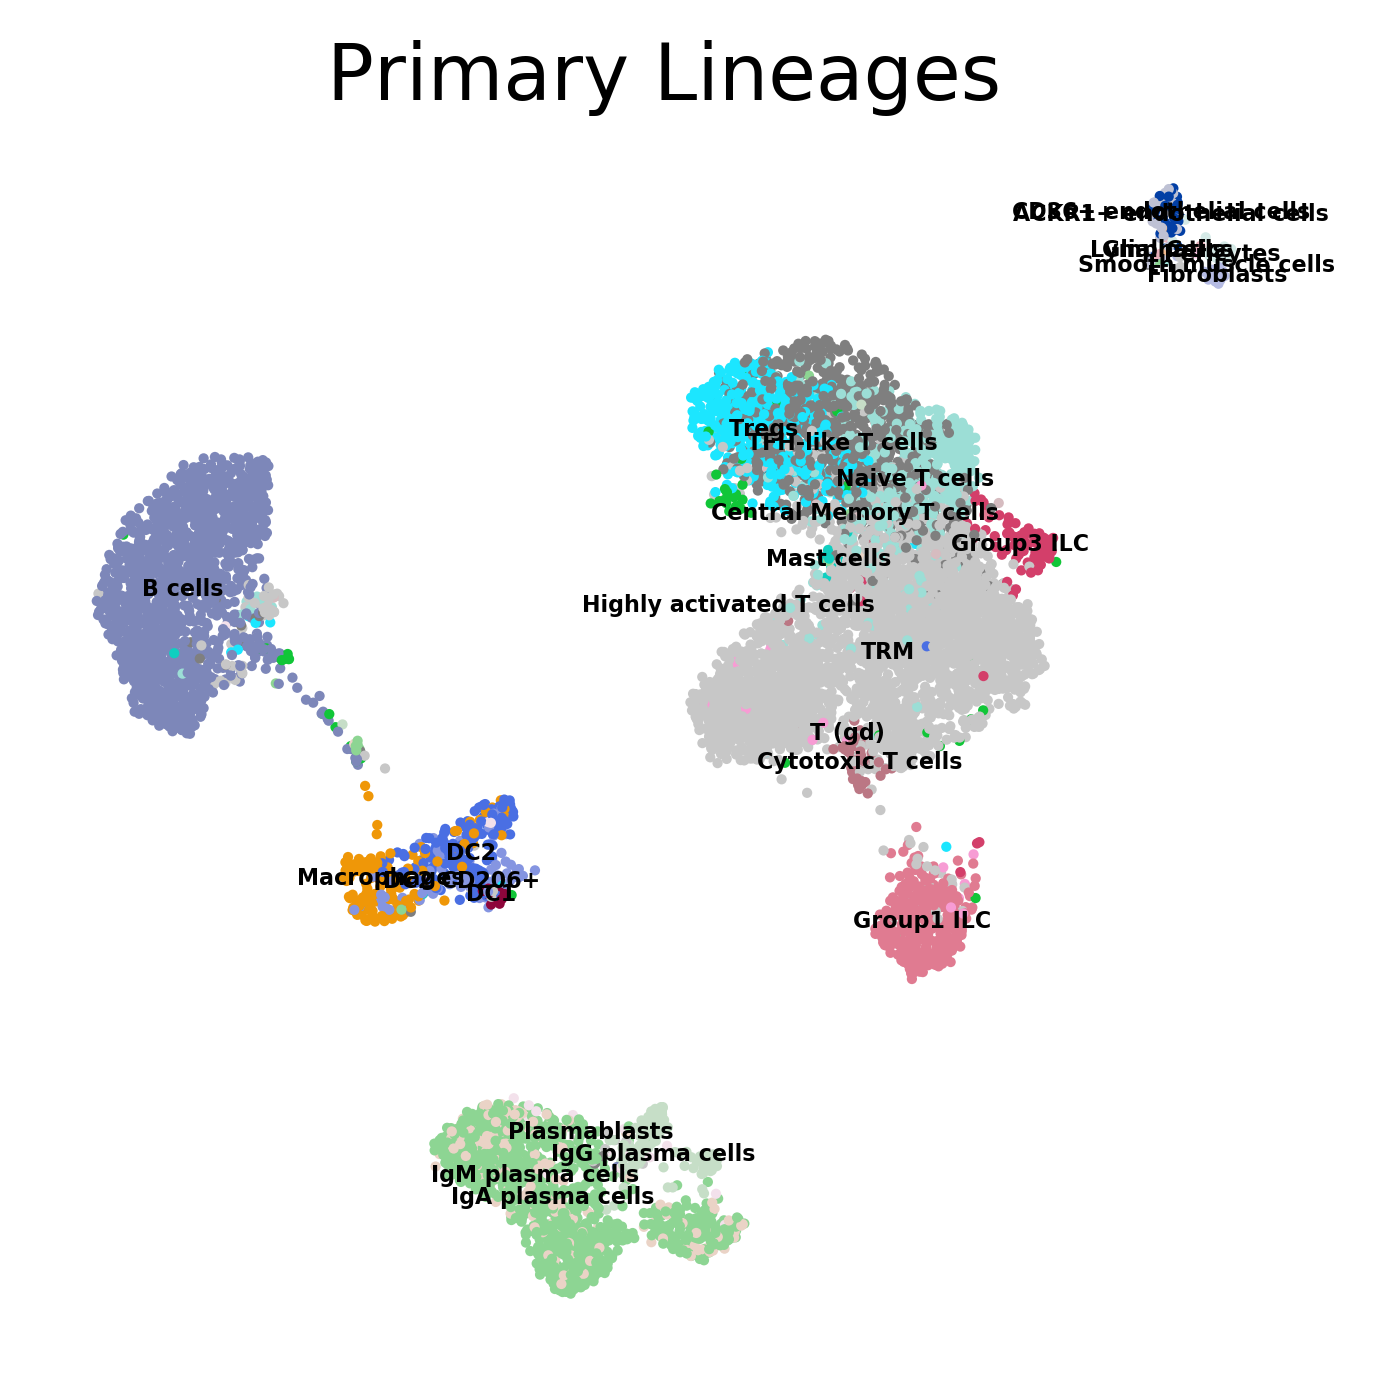

In [38]:
sc.settings.set_figure_params(dpi=200, facecolor='white')
sc.pl.umap(adata, color="Primary Lineages", legend_loc="on data", legend_fontsize=4, frameon=False)

In [ ]:
sc.settings.set_figure_params(dpi=200, facecolor='white')
sc.pl.scatter(adata, "X", "Y", "Primary Lineages", legend_loc="on data", legend_fontsize=4, frameon=False)

In [ ]:
sc.settings.set_figure_params(dpi=200, facecolor='white')
sc.pl.scatter(adata, "X", "Y", "batch", legend_loc="on data", legend_fontsize=4, frameon=False)

In [ ]:
sc.tl.tsne(adata, n_pcs=50)

In [ ]:
sc.settings.set_figure_params(dpi=200, facecolor='white')
sc.pl.tsne(adata, color="Primary Lineages", legend_loc="on data", legend_fontsize=4, frameon=False)

In [ ]:
adata.obs['batch'] = adata.obs.NAME.str[0:3]

In [ ]:
sc.pl.umap(adata, color="batch", frameon=False)

In [ ]:
sc.pl.tsne(adata, color="batch", frameon=False)

In [41]:
sc.tl.paga(adata, groups="Primary Lineages")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


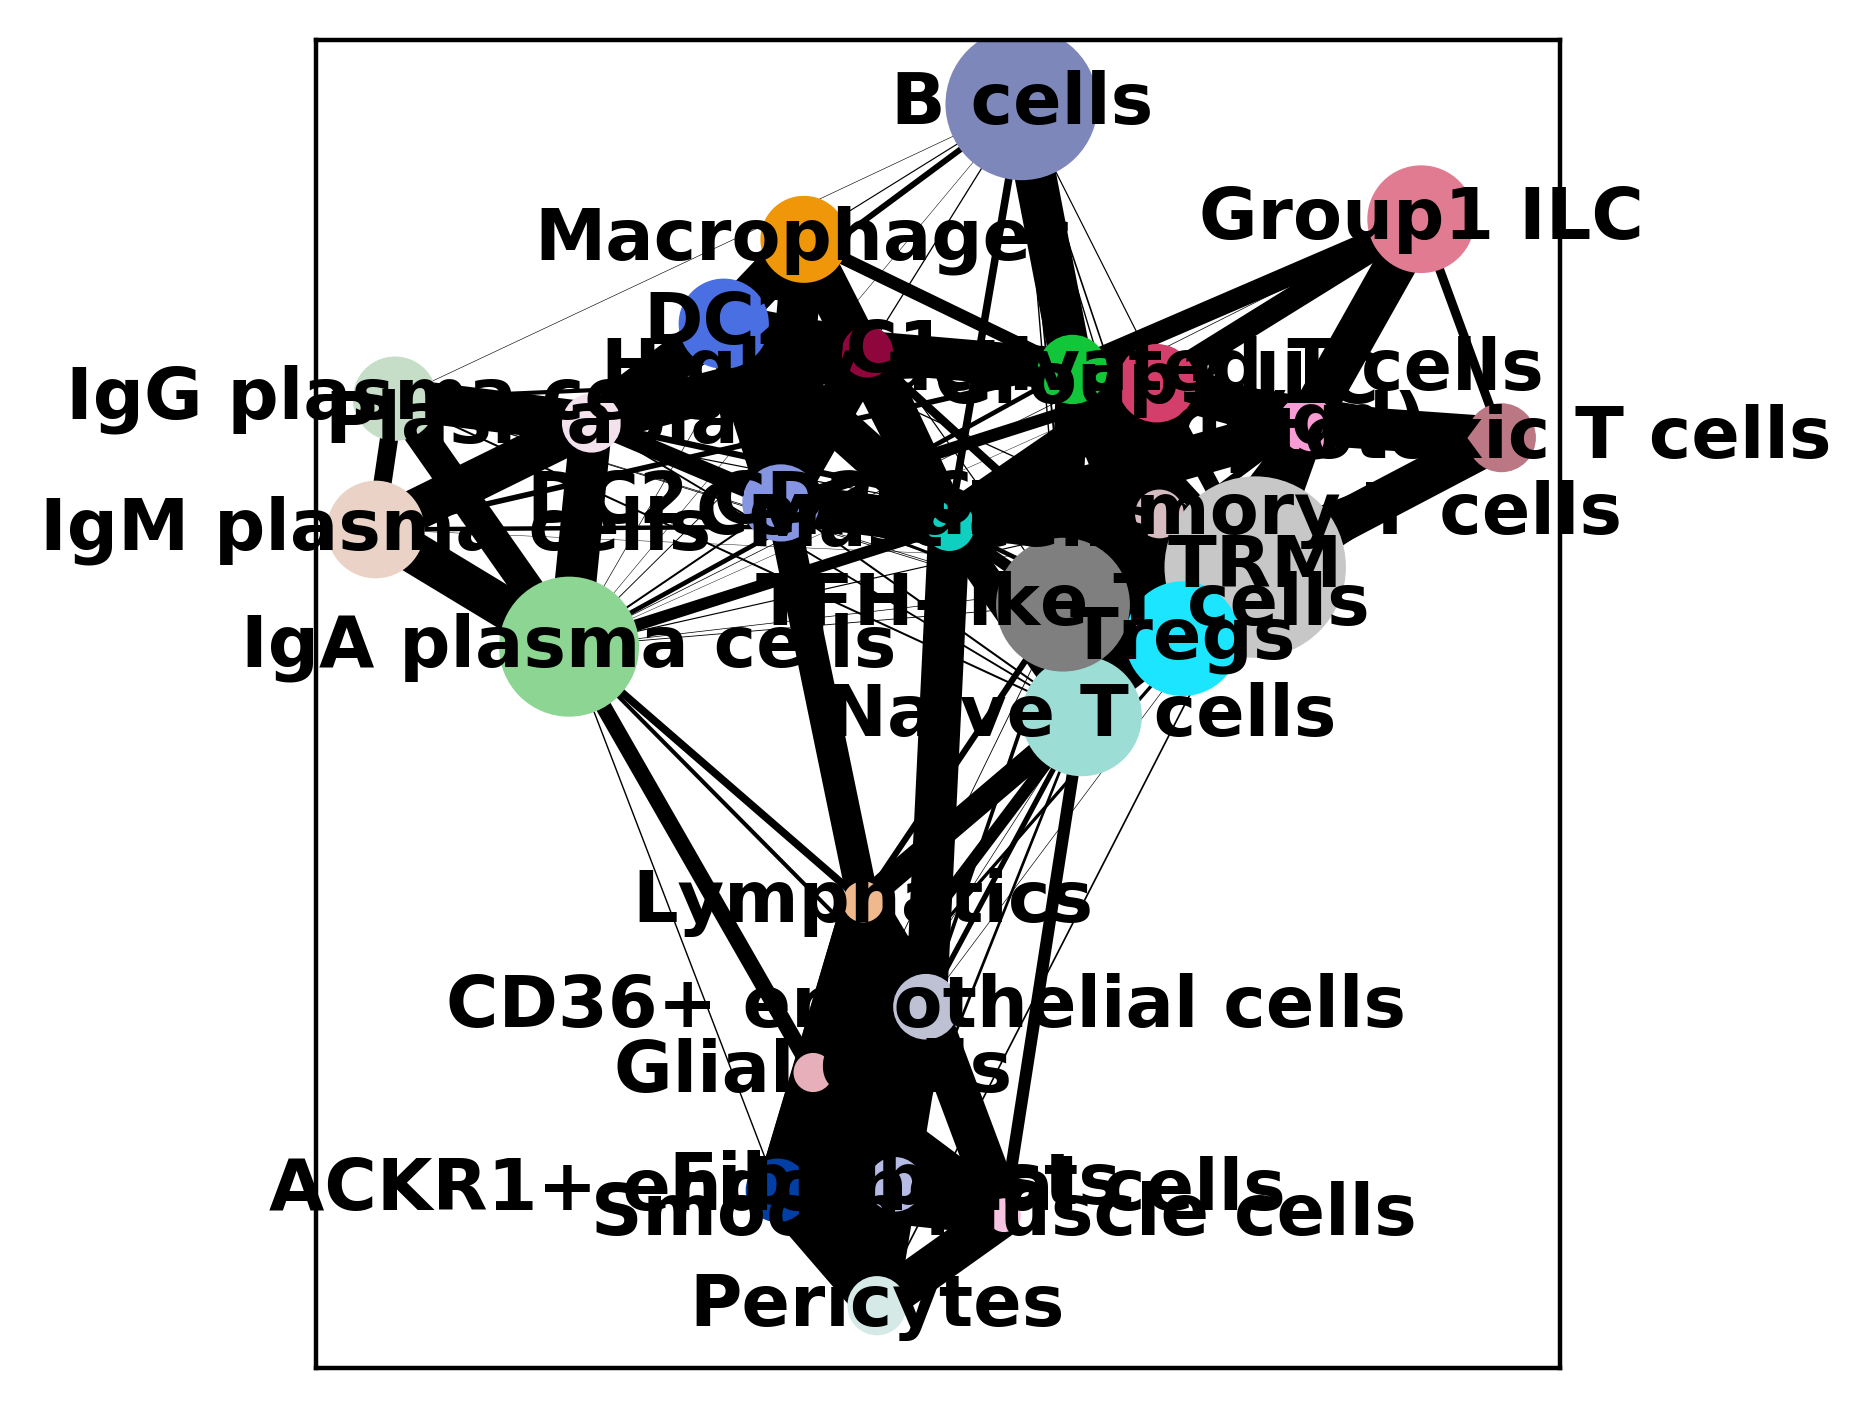

In [43]:
sc.pl.paga(adata, color="Primary Lineages")